<a href="https://colab.research.google.com/github/Aryan8912/PPO_with_TorchRL/blob/main/PPO_with_TorchRL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install torchrl
!pip install gym[mujoco]
!pip install tqdm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 27.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 359.9/359.9 kB 29.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 29.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 243.4/243.4 kB 20.9 MB/s eta 0:00:00


In [ ]:
import warnings
warnings.filterwarnings("ignore")
from torch import multiprocessing


from collections import defaultdict

import matplotlib.pyplot as plt
import torch
from tensordict.nn import TensorDictModule
from tensordict.nn.distributions import NormalParamExtractor
from torch import nn
from torchrl.collectors import SyncDataCollector
from torchrl.data.replay_buffers import ReplayBuffer
from torchrl.data.replay_buffers.samplers import SamplerWithoutReplacement
from torchrl.data.replay_buffers.storages import LazyTensorStorage
from torchrl.envs import (Compose, DoubleToFloat, ObservationNorm, StepCounter,
                          TransformedEnv)
from torchrl.envs.libs.gym import GymEnv
from torchrl.envs.utils import check_env_specs, ExplorationType, set_exploration_type
from torchrl.modules import ProbabilisticActor, TanhNormal, ValueOperator
from torchrl.objectives import ClipPPOLoss
from torchrl.objectives.value import GAE
from tqdm import tqdm

In [ ]:
is_fork = multiprocessing.get_start_method() == "fork"
device = (
    torch.device(0)
    if torch.cuda.is_available() and not is_fork
    else torch.device("cpu")
)
num_cells = 256 # number of cells in each layer i.e. output dim.
lr = 3e-4
max_grad_norm = 1.0

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
frames_per_episode = 1000
# for a complete traning, bring the number of grames up to 1M
total_frames = 50_000

In [ ]:
sub_batch_size = 64 # cardinality of the sub-samples gathered from the current data in the inner loop
num_epochs = 10 # optimizatioin steps per batch of data collected
clip_epsilon = (
    0.2 # clip value for ppo loss: see the equation in the intro for more context.
)
gamma = 0.99
lmbda = 0.95
entropy_eps = 1e-4

In [ ]:
base_env = GymEnv("InvertedDoublePendulum-v4", device=device)

In [ ]:
env = TransformedEnv(
    base_env,
    Compose(
        # normalize observations
        ObservationNorm(in_keys=["observation"]),
        DoubleToFloat(),
        StepCounter(),
    ),
)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
env.transform[0].init_stats(num_iter=1000, reduce_dim=0, cat_dim=0)

In [ ]:
print("normalization constant shape:", env.transform[0].loc.shape)

normalization constant shape: torch.Size([11])


In [ ]:
print("observation space:", env.observation_spec)
print("reward_spec:", env.reward_spec)
print("input_spec:", env.input_spec)
print("action_spec (as defined by input_spec):", env.action_spec)

observation space: Composite(
    observation: UnboundedContinuous(
        shape=torch.Size([11]),
        space=ContinuousBox(
            low=Tensor(shape=torch.Size([11]), device=cuda:0, dtype=torch.float32, contiguous=True),
            high=Tensor(shape=torch.Size([11]), device=cuda:0, dtype=torch.float32, contiguous=True)),
        device=cuda:0,
        dtype=torch.float32,
        domain=continuous),
    step_count: BoundedDiscrete(
        shape=torch.Size([1]),
        space=ContinuousBox(
            low=Tensor(shape=torch.Size([1]), device=cuda:0, dtype=torch.int64, contiguous=True),
            high=Tensor(shape=torch.Size([1]), device=cuda:0, dtype=torch.int64, contiguous=True)),
        device=cuda:0,
        dtype=torch.int64,
        domain=discrete),
    device=cuda:0,
    shape=torch.Size([]))
reward_spec: UnboundedContinuous(
    shape=torch.Size([1]),
    space=ContinuousBox(
        low=Tensor(shape=torch.Size([1]), device=cuda:0, dtype=torch.float32, contiguous=

In [ ]:
check_env_specs(env)

2025-01-09 12:26:13,035 [torchrl][INFO] check_env_specs succeeded!


In [ ]:
rollout = env.rollout(3)
print("rollout of three steps:", rollout)
print("shape of the rollout TensorDict:", rollout.batch_size)

rollout of three steps: TensorDict(
    fields={
        action: Tensor(shape=torch.Size([3, 1]), device=cuda:0, dtype=torch.float32, is_shared=True),
        done: Tensor(shape=torch.Size([3, 1]), device=cuda:0, dtype=torch.bool, is_shared=True),
        next: TensorDict(
            fields={
                done: Tensor(shape=torch.Size([3, 1]), device=cuda:0, dtype=torch.bool, is_shared=True),
                observation: Tensor(shape=torch.Size([3, 11]), device=cuda:0, dtype=torch.float32, is_shared=True),
                reward: Tensor(shape=torch.Size([3, 1]), device=cuda:0, dtype=torch.float32, is_shared=True),
                step_count: Tensor(shape=torch.Size([3, 1]), device=cuda:0, dtype=torch.int64, is_shared=True),
                terminated: Tensor(shape=torch.Size([3, 1]), device=cuda:0, dtype=torch.bool, is_shared=True),
                truncated: Tensor(shape=torch.Size([3, 1]), device=cuda:0, dtype=torch.bool, is_shared=True)},
            batch_size=torch.Size([3]),


In [ ]:
action_net = nn.Sequential(
    nn.LazyLinear(num_cells, device=device),
    nn.Tanh(),
    nn.LazyLinear(num_cells, device=device),
    nn.Tanh(),
    nn.LazyLinear(num_cells, device=device),
    nn.Tanh(),
    nn.LazyLinear(2 * env.action_spec.shape[-1], device=device),
    NormalParamExtractor(),
)

In [ ]:
policy_module = TensorDictModule(
    action_net, in_keys=["observation"], out_keys=["loc", "scale"]
)

In [ ]:
policy_module = ProbabilisticActor(
    module=policy_module,
    spec=env.action_spec,
    in_keys=["loc", "scale"],
    distribution_class=TanhNormal,
    distribution_kwargs={
        "min": env.action_spec.space.low,
        "max": env.action_spec.space.high,
    },
    return_log_prob=True,
    # we'll need the log-prob for the numerator of the importance weights
)

In [ ]:
value_net = nn.Sequential(
    nn.LazyLinear(num_cells, device=device),
    nn.Tanh(),
    nn.LazyLinear(num_cells, device=device),
    nn.Tanh(),
    nn.LazyLinear(num_cells, device=device),
    nn.Tanh(),
    nn.LazyLinear(1, device=device),
)

value_module = ValueOperator(
    module=value_net,
    in_keys=["observation"],
)

In [ ]:
print("Running policy:", policy_module(env.reset()))
print("Running value", value_module(env.reset()))

Running policy: TensorDict(
    fields={
        action: Tensor(shape=torch.Size([1]), device=cuda:0, dtype=torch.float32, is_shared=True),
        done: Tensor(shape=torch.Size([1]), device=cuda:0, dtype=torch.bool, is_shared=True),
        loc: Tensor(shape=torch.Size([1]), device=cuda:0, dtype=torch.float32, is_shared=True),
        observation: Tensor(shape=torch.Size([11]), device=cuda:0, dtype=torch.float32, is_shared=True),
        sample_log_prob: Tensor(shape=torch.Size([]), device=cuda:0, dtype=torch.float32, is_shared=True),
        scale: Tensor(shape=torch.Size([1]), device=cuda:0, dtype=torch.float32, is_shared=True),
        step_count: Tensor(shape=torch.Size([1]), device=cuda:0, dtype=torch.int64, is_shared=True),
        terminated: Tensor(shape=torch.Size([1]), device=cuda:0, dtype=torch.bool, is_shared=True),
        truncated: Tensor(shape=torch.Size([1]), device=cuda:0, dtype=torch.bool, is_shared=True)},
    batch_size=torch.Size([]),
    device=cuda:0,
    is_sh

In [ ]:
frames_per_episode = 1000
# for a complete traning, bring the number of grames up to 1M
total_frames = 50_000
frames_per_batch = frames_per_episode # Define frames_per_batch here, assigning it the value of frames_per_episode

# ... (Rest of your code) ...

collector = SyncDataCollector(
    env,
    policy_module,
    frames_per_batch=frames_per_batch,
    total_frames=total_frames,
    split_trajs=False,
    device=device,
)

In [ ]:
replay_buffer = ReplayBuffer(
    storage=LazyTensorStorage(max_size=frames_per_batch),
    sampler=SamplerWithoutReplacement(),
)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
advantage_module = GAE(
    gamma=gamma, lmbda=lmbda, value_network=value_module, average_gae=True
)

loss_module = ClipPPOLoss(
    actor_network = policy_module,
    critic_network = value_module,
    clip_epsilon = clip_epsilon,
    entropy_bonous=bool(entropy_eps),
    entropy_coef=entropy_eps,
    # these keys by default but we set this for completeness
    critic_coef=1.0,
    loss_critic_type="smooth_l1",

)

optim = torch.optim.Adam(loss_module.parameters(), lr)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optim, total_frames // frames_per_batch, 0.0
)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
logs = defaultdict(list)
pbar = tqdm(total=total_frames)
eval_str = ""

# We iterate over the collector until it reaches the total number of frames it was
# designed to collect:
for i, tensordict_data in enumerate(collector):
    # we now have a batch of data to work with. Let's learn something from it.
    for _ in range(num_epochs):
        # We'll need an "advantage" signal to make PPO work.
        # We re-compute it at each epoch as its value depends on the value
        # network which is updated in the inner loop.
        advantage_module(tensordict_data)
        data_view = tensordict_data.reshape(-1)
        replay_buffer.extend(data_view.cpu())
        for _ in range(frames_per_batch // sub_batch_size):
            subdata = replay_buffer.sample(sub_batch_size)
            loss_vals = loss_module(subdata.to(device))
            loss_value = (
                loss_vals["loss_objective"]
                + loss_vals["loss_critic"]
                + loss_vals["loss_entropy"]
            )

            # Optimization: backward, grad clipping and optimization step
            loss_value.backward()
            # this is not strictly mandatory but it's good practice to keep
            # your gradient norm bounded
            torch.nn.utils.clip_grad_norm_(loss_module.parameters(), max_grad_norm)
            optim.step()
            optim.zero_grad()

    logs["reward"].append(tensordict_data["next", "reward"].mean().item())
    pbar.update(tensordict_data.numel())
    cum_reward_str = (
        f"average reward={logs['reward'][-1]: 4.4f} (init={logs['reward'][0]: 4.4f})"
    )
    logs["step_count"].append(tensordict_data["step_count"].max().item())
    stepcount_str = f"step count (max): {logs['step_count'][-1]}"
    logs["lr"].append(optim.param_groups[0]["lr"])
    lr_str = f"lr policy: {logs['lr'][-1]: 4.4f}"
    if i % 10 == 0:
        # We evaluate the policy once every 10 batches of data.
        # Evaluation is rather simple: execute the policy without exploration
        # (take the expected value of the action distribution) for a given
        # number of steps (1000, which is our ``env`` horizon).
        # The ``rollout`` method of the ``env`` can take a policy as argument:
        # it will then execute this policy at each step.
        with set_exploration_type(ExplorationType.MEAN), torch.no_grad():
            # execute a rollout with the trained policy
            eval_rollout = env.rollout(1000, policy_module, exploration_type=ExplorationType.MODE)
            logs["eval reward"].append(eval_rollout["next", "reward"].mean().item())
            logs["eval reward (sum)"].append(
                eval_rollout["next", "reward"].sum().item()
            )
            logs["eval step_count"].append(eval_rollout["step_count"].max().item())
            eval_str = (
                f"eval cumulative reward: {logs['eval reward (sum)'][-1]: 4.4f} "
                f"(init: {logs['eval reward (sum)'][0]: 4.4f}), "
                f"eval step-count: {logs['eval step_count'][-1]}"
            )
            del eval_rollout
    pbar.set_description(", ".join([eval_str, cum_reward_str, stepcount_str, lr_str]))

    # We're also using a learning rate scheduler. Like the gradient clipping,
    # this is a nice-to-have but nothing necessary for PPO to work.
    scheduler.step()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)

  2%|▏         | 1000/50000 [02:26<1:59:50,  6.81it/s]

  2%|▏         | 1000/50000 [00:03<03:10, 256.61it/s]

TypeError: EnvBase.rollout() got an unexpected keyword argument 'exploration_type'

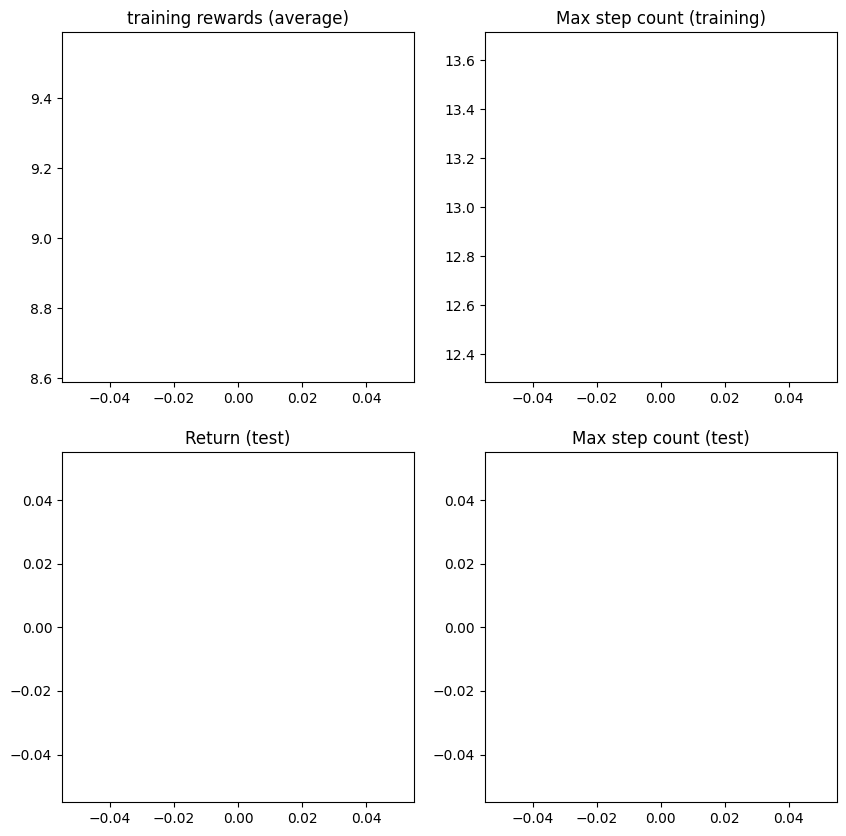

In [ ]:
plt.figure(figsize=(10, 10))
plt.subplot(2, 2, 1)
plt.plot(logs["reward"])
plt.title("training rewards (average)")
plt.subplot(2, 2, 2)
plt.plot(logs["step_count"])
plt.title("Max step count (training)")
plt.subplot(2, 2, 3)
plt.plot(logs["eval reward (sum)"])
plt.title("Return (test)")
plt.subplot(2, 2, 4)
plt.plot(logs["eval step_count"])
plt.title("Max step count (test)")
plt.show()